# PIMA INDIANS DIABETES_Convex_Optimization_Project
by AZOULAY Yehoudah, BEHAT Sami, EL HARISSI Anas

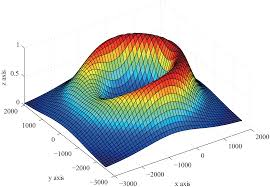

### Table of Contents

* [Part I](#Part1)
* [Part II](#Part2)
    * [Initial SVM](#section_2_1)
    * [Dealing with outliers](#Section_2_2)
    * [Standardization](#Section_2_3)
    * [Score with our features optimized](#Section_2_4)
    * [LOOP to reduce random impact](#Section_2_5)
* [Part III](#Part3)
    * [General GridSearch](#section_3_1)
    * [Choice of the degree kernel](#Section_3_2)
    * [Choice of the C parameter](#Section_3_3)
        * [Randomized GridSearch](#section_3_3_1)
        * [GridSearch](#section_3_3_2)
        * [Impact of C parameter](#section_3_3_3)
    * [Choice of learning rate](#Section_3_4)
        * [SGD Classifier for SVM](#section_3_4_1)
        * [Grid for choosing alpha](#section_3_4_2)
    * [Keras optimizers](#Section_3_5)
        * [Preprocessing](#section_3_5_1)
        * [GD+ adadelta](#section_3_5_2)
        * [SGD](#section_3_5_3)
        * [SGD+ momentum](#section_3_5_4)
        * [Results on all the training phase](#section_3_5_5)
        * [Results on first steps](#section_3_5_6)
        * [Results on last steps](#section_3_5_7)
        * [Best batch size](#section_3_5_8)
    * [Best parameters for the recall score](#Section_3_6)


# Part I : Dataset Presentation and cleaning  <a class="anchor" id="Part1"></a>

In [ ]:
# Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load Data
dataset = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')

In [ ]:
dataset.info() #details about our dataset

In [ ]:
# checking the balance of the data by plotting the count of targets by their value
p=dataset.Outcome.value_counts().plot(kind="bar", title = "Balance")
print("balance : \n", dataset.Outcome.value_counts())

The above graph shows that the data is biased towards datapoints having target value as 1 where it means that diabetes was not present actually. The number of non-diabetics is almost twice the number of diabetic patients.

In [ ]:
dataset.describe().T

**We observe a problem, some columns min are equal to zero wich is non-sense.**

1.   Glucose
2.   BloodPressure
1.   SkinThickness
2.   Insulin
1.   BMI

These kind of values cannot be equal to zero, that means in this case it's in fact missing values.

It is better to replace zeros with '*nan*' since after that counting them would be easier and zeros need to be replaced with suitable values





In [ ]:
#changing from 0 to Nan values for the five columns
dataset[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = dataset[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0,np.NaN)

In [ ]:
# showing the count of Nans
print(dataset.isnull().sum())

In [ ]:
#replacing Nans values with the median for each columns
dataset['Glucose'].fillna(dataset['Glucose'].median(), inplace = True)
dataset['BloodPressure'].fillna(dataset['BloodPressure'].median(), inplace = True)
dataset['SkinThickness'].fillna(dataset['SkinThickness'].median(), inplace = True)
dataset['Insulin'].fillna(dataset['Insulin'].median(), inplace = True)
dataset['BMI'].fillna(dataset['BMI'].median(), inplace = True)

In [ ]:
# View the repartition of patients based on each feature
for column in dataset.columns:
  g = sns.FacetGrid(dataset, col='Outcome')
  g.map(plt.hist, column, bins=20)

In [ ]:
# Plot the Pearson's Correlation Matrix
plt.figure(figsize=(8,8))  
#plt.title('Pearson s Correlation Matrix')
p=sns.heatmap(dataset.corr(), annot=True) 

In [ ]:
import seaborn as sns
plt.rcdefaults()
g= sns.pairplot(dataset, hue="Outcome")

# Part II : ML features optimization  <a class="anchor" id="Part2"></a>

## Initial SVM  <a class="anchor" id="section_2_1"></a>

In [ ]:
# Split X and y
X = dataset.copy()
X.drop(columns = ['Outcome'], inplace = True)
y = dataset['Outcome'].copy()

In [ ]:
# Split test and train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics
import time

start = time.time()
end = time.time() - start 
first_svm=SVC(kernel='linear')
# Entraînement
first_svm.fit(X_train, y_train)
print("Time to converge : ", end)
# Test
y_pred = first_svm.predict(X_test)

# Calcul et affichage du score
print("Accuracy score: ",metrics.accuracy_score(y_test, y_pred)*100,"%")
print("Recall score: ",metrics.recall_score(y_test, y_pred)*100,"%")




## Dealing with outliers  <a class="anchor" id="section_2_2"></a>

In [ ]:
plt.figure(figsize=(8,8))
boxplot = X_train.boxplot()

In [ ]:
# Correcting outliers
for c in X_train.columns:
  sup=X_train[c].mean()+1.7*X_train[c].std()
  inf=X_train[c].mean()-1.7*X_train[c].std()
  X_train.loc[X_train[c]>sup,c]=sup
  X_train.loc[X_train[c]<inf,c]=inf

In [ ]:
plt.figure(figsize=(8,8))
boxplot = X_train.boxplot()

## Standardization <a class="anchor" id="section_2_3"></a>

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

## Score with our features optimized <a class="anchor" id="section_2_4"></a>

In [ ]:
start = time.time()

first_svm=SVC(kernel='linear')
# Entraînement
first_svm.fit(X_train, y_train)

# Test
y_pred = first_svm.predict(X_test)

# Calcul et affichage du score
print("Accuracy score: ",metrics.accuracy_score(y_test, y_pred)*100,"%")
print("Recall score: ",metrics.recall_score(y_test, y_pred)*100,"%")

end = time.time() - start 
print("Time to converge : ", end)

In [ ]:
y_pred=first_svm.predict(X_test)
import matplotlib.pyplot as plt
confusion_matrix = pd.crosstab(y_test,y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(5,5))
plt.title("Confusion matrix with accuracy metric optimized",fontsize=10)
sns.heatmap(confusion_matrix, annot=True)

## *LOOP* to reduce random impact <a class="anchor" id="section_2_5"></a>




In [ ]:
# Split X and y
X = dataset.copy()
X.drop(columns = ['Outcome'], inplace = True)
y = dataset['Outcome'].copy()

In [ ]:
results=[]
time_to_compute=[]
for i in range(45):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy()
  start = time.time()
  svm=SVC()
  svm.fit(X_train, y_train)
  y_pred=svm.predict(X_test)
  end = time.time() - start 
  results.append(metrics.accuracy_score(y_test, y_pred))
  time_to_compute.append(end)


In [ ]:
results_with_optimizations=[]
time_to_compute_opti=[]
for i in range(45):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
  #outliers correction
  for c in X_train.columns:
    sup=X_train[c].mean()+1.7*X_train[c].std()
    inf=X_train[c].mean()-1.7*X_train[c].std()
    X_train.loc[X_train[c]>sup,c]=sup
    X_train.loc[X_train[c]<inf,c]=inf
  #features scaling
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train=scaler.transform(X_train)
  X_test=scaler.transform(X_test)
  start = time.time()
  #training
  svm=SVC(kernel='linear', C=0.1)
  svm.fit(X_train, y_train)
  y_pred=svm.predict(X_test)
  end = time.time() - start 
  results_with_optimizations.append(metrics.accuracy_score(y_test, y_pred))
  time_to_compute_opti.append(end)

In [ ]:
from statistics import mean 
print("Mean with no scaling (on 45 splits): ",mean(results))
print("Mean with scaling (on 45splits ): ",mean(results_with_optimizations))

In [ ]:
plot2=pd.DataFrame({'Time to compute with no standardization':time_to_compute,'Time to compute with standardization':time_to_compute_opti})
plot2.plot()
plt.ylabel('time')


In [ ]:
print("Time to compute with no opimization (on 45 splits): ",mean(time_to_compute))
print("Time to compute opimizations (on 45 splits): ",mean(time_to_compute_opti))

# Part III : SVM optimization <a class="anchor" id="Part3"></a>

## General GridSearch <a class="anchor" id="section_3_1"></a>

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = [{'kernel':['poly'],'degree':[1,2,3,4,5,6,7],'C':[0.001,0.1,1,10,100,1000]},
              {'kernel':['rbf'],'C':[0.001,0.1,1,10,100,1000]},
              {'kernel':['sigmoid'],'C':[0.001,0.1,1,10,100,1000]}]

grid_svm = GridSearchCV(SVC(),param_grid=param_grid,scoring='accuracy', cv=5, refit=True)

grid_svm.fit(X_train, y_train)
grid_svm.best_params_

result_svm = grid_svm.cv_results_
print("The best parmeters are : "+ str(grid_svm.best_params_))

initial_svm = grid_svm.best_estimator_

In [ ]:
initial_svm.score(X_test,y_test)

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test,initial_svm.predict(X_test))

## Choice of the degree kernel <a class="anchor" id="section_3_2"></a>

In [ ]:
param_grid = {'degree':list(range(1,8))}

grid_svm = GridSearchCV(SVC(kernel='poly'),param_grid=param_grid,scoring='accuracy', cv=5, refit=True)

grid_svm.fit(X_train, y_train)
grid_svm.best_params_

result_svm = grid_svm.cv_results_
print("The best parmeters are : "+ str(grid_svm.best_params_))

final_svm = grid_svm.best_estimator_

In [ ]:
scores_train=[]
scores_test=[]
for i in range(1,8):
  svm=SVC(kernel='poly',degree=i)
  svm.fit(X_train,y_train)
  scores_train.append(svm.score(X_train,y_train))
  scores_test.append(svm.score(X_test,y_test))


In [ ]:
#display result
df2 = pd.DataFrame({
    'mean score on validation sets':result_svm['mean_test_score'],
    'score on test set':scores_test,
    'score on train set':scores_train

   }, index=result_svm['param_degree'])

df2.plot()
plt.legend(loc='best',fontsize=8)
plt.xlabel('degree')
plt.title('Choice of the Kernel\'s degree')

## Choice of the C parameter <a class="anchor" id="section_3_3"></a>

### Randomized GridSearch <a class="anchor" id="section_3_3_1"></a>


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import  RandomizedSearchCV
import scipy

param_grid = {'C':scipy.stats.expon(scale=100)}

grid_svm =  RandomizedSearchCV(SVC(kernel='linear'),param_distributions=param_grid,scoring='accuracy', cv=5, n_iter=100,refit=True)

grid_svm.fit(X_train, y_train)
grid_svm.best_params_

result_svm = grid_svm.cv_results_
print("The best parmeters are : "+ str(grid_svm.best_params_))

final_svm = grid_svm.best_estimator_

### GridSearch <a class="anchor" id="section_3_3_2"></a>

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.01,0.1,1,10,100,1000,10000]}

grid_svm = GridSearchCV(SVC(kernel='linear'),param_grid=param_grid,scoring='accuracy', cv=5, refit=True)

grid_svm.fit(X_train, y_train)
grid_svm.best_params_

result_svm = grid_svm.cv_results_
print("The best parmeters are : "+ str(grid_svm.best_params_))

final_svm = grid_svm.best_estimator_

### Impact of C parameter <a class="anchor" id="section_3_3_3"></a>

In [ ]:
scores_train=[]
scores_test=[]
for el in [0.01,0.1,1,10,100,1000,10000]:
  svm=SVC(kernel='linear',C=el)
  svm.fit(X_train,y_train)
  scores_train.append(svm.score(X_train,y_train))
  scores_test.append(svm.score(X_test,y_test))


In [ ]:
scores_train

In [ ]:
#display result
df2 = pd.DataFrame({
    'mean score on validation sets':result_svm['mean_test_score'],
    'score on train set':scores_train
   }, index=result_svm['param_C'])



In [ ]:
df2.plot(logx=True)
plt.xlabel('C parameter')
plt.title('Choice of the C parameter')

## Choice of learning rate <a class="anchor" id="section_3_4"></a>

### SGD Classifier for SVM <a class="anchor" id="section_3_4_1"></a>

In [ ]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(loss='hinge',penalty='l2')

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
#initial score
clf.score(X_test,y_test)

### Grid for choosing alpha <a class="anchor" id="section_3_4_2"></a>

In [ ]:
param_grid = {'alpha':[0.0001,0.001,0.01,0.1,1,10]}

grid_svm = GridSearchCV(linear_model.SGDClassifier(loss='hinge',penalty='l2',max_iter=10000,tol=1e-3),param_grid=param_grid,scoring='accuracy', cv=5, refit=True)

grid_svm.fit(X_train, y_train)
grid_svm.best_params_

result_svm = grid_svm.cv_results_
print("The best parmeters are : "+ str(grid_svm.best_params_))

final_svm = grid_svm.best_estimator_

In [ ]:
#display result
df2 = pd.DataFrame({
    'mean_score_test':result_svm['mean_test_score'],

   }, index=result_svm['param_alpha'])
df2.plot(logx=True)
plt.xlabel('learning rate')
plt.title('Choice of the Learning Rate\'s value')

## Keras optimizers <a class="anchor" id="section_3_5"></a>

### Preprocessing <a class="anchor" id="section_3_5_1"></a>

In [ ]:
# Split X and y
X = dataset.copy()
X.drop(columns = ['Outcome'], inplace = True)
y = dataset['Outcome'].copy()
#outliers correction
for c in X.columns:
  sup=X[c].mean()+1.7*X[c].std()
  inf=X[c].mean()-1.7*X[c].std()
  X.loc[X[c]>sup,c]=sup
  X.loc[X[c]<inf,c]=inf

scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

### GD+ adadelta <a class="anchor" id="section_3_5_2"></a>

In [ ]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(8, activation='relu'))
model.add(Dense(1, W_regularizer=regularizers.l2(0.01),activation='sigmoid'))
model.compile(loss='hinge',
              optimizer='adadelta',
              metrics=['accuracy'])
history_gd_ada=model.fit(X,y.to_numpy(),epochs=600,validation_split=0.33,batch_size=514)

### SGD <a class="anchor" id="section_3_5_3"></a>

In [ ]:

model = Sequential()
model.add(Dense(8, activation='relu'))
model.add(Dense(1, W_regularizer=regularizers.l2(0.01),activation='sigmoid'))
model.compile(loss='hinge',
              optimizer='sgd',
              metrics=['accuracy'])
history_sgd=model.fit(X,y.to_numpy(),epochs=600,validation_split=0.33)

### SGD+ momentum <a class="anchor" id="section_3_5_4"></a>

In [ ]:
from keras import optimizers 
model = Sequential()
model.add(Dense(8, activation='relu'))
model.add(Dense(1, W_regularizer=regularizers.l2(0.01),activation='sigmoid'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(loss='hinge',
              optimizer=sgd,
              metrics=['accuracy'])
history_sgd_momentum=model.fit(X,y.to_numpy(),epochs=600,validation_split=0.33)

### Results on all the training phase <a class="anchor" id="section_3_5_5"></a>

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_sgd.history['val_accuracy'])
plt.plot(history_sgd_momentum.history['val_accuracy'])
plt.plot(history_gd_ada.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['SGD', 'SGD momentum','GD adadelta'], loc='lower right')
plt.show()

### Results on first steps. <a class="anchor" id="section_3_5_6"></a>

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_sgd.history['val_accuracy'][0:100])
plt.plot(history_sgd_momentum.history['val_accuracy'][0:100])
plt.plot(history_gd_ada.history['val_accuracy'][0:100])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['SGD', 'SGD momentum','GD adadelta'], loc='lower right')
plt.show()

### Results on last steps <a class="anchor" id="section_3_5_7"></a>

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_sgd.history['val_accuracy'][400:599])
plt.plot(history_sgd_momentum.history['val_accuracy'][400:599])
plt.plot(history_gd_ada.history['val_accuracy'][400:599])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['SGD', 'SGD momentum','GD adadelta'], loc='lower right')
plt.show()

### Best batch size <a class="anchor" id="section_3_5_8"></a>

In [ ]:
histories=[]
final_acc=[]
for i in [1,10,50,100,200]:
  model = Sequential()
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, W_regularizer=regularizers.l2(0.01),activation='sigmoid'))
  model.compile(loss='hinge',
                optimizer='adadelta',
                metrics=['accuracy'])
  history=model.fit(X,y.to_numpy(),epochs=100,validation_split=0.33,batch_size=i)
  histories.append(history)
  final_acc.append(history.history['val_accuracy'][-1])

In [ ]:
plt.figure(figsize=(8,8))

for i in range(len(histories)):
  plt.plot(histories[i].history['val_accuracy'])


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Batch_size1','Batch_size10','Batch_size50','Batch_size100','Batch_size200'], loc='lower right')
plt.show()

In [ ]:
#display result
df2 = pd.DataFrame({
    'batch_size':final_acc,
   }, index=[1,10,50,100,200])
df2.plot.bar(logy=True)
plt.xlabel('batch size')
plt.title('Final accuracy with different batch size')

## Best parameters for the recall score <a class="anchor" id="section_3_6"></a>

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = [{'kernel':['poly'],'degree':[1,2,3,4,5,6,7],'C':[0.001,0.1,1,10,100,1000]},
              {'kernel':['rbf'],'C':[0.001,0.1,1,10,100,1000]},
              {'kernel':['sigmoid'],'C':[0.001,0.1,1,10,100,1000]}]

grid_svm = GridSearchCV(SVC(),param_grid=param_grid,scoring='recall', cv=5, refit=True)

grid_svm.fit(X_train, y_train)
grid_svm.best_params_

result_svm = grid_svm.cv_results_
print("The best parmeters are : "+ str(grid_svm.best_params_))

final_svm = grid_svm.best_estimator_

In [ ]:
from sklearn.metrics import recall_score
print("Recall score on test set after optimizations :",recall_score(y_test,final_svm.predict(X_test))*100,"%")

In [ ]:
y_pred=final_svm.predict(X_test)
import matplotlib.pyplot as plt
confusion_matrix = pd.crosstab(y_test,y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(5,5))
plt.title("Confusion matrix with recall metric optimized",fontsize=10)
sns.heatmap(confusion_matrix, annot=True)